# Imports

In [232]:
import numpy as np
import scipy.io
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec
%matplotlib inline

import os
from os import listdir
from os.path import isfile, join

import scipy.signal

# Globals

In [163]:
num_channels = 16

##### Plot cosmetics

In [194]:
gray_color = (0.4, 0.4, 0.4)
darkgray_color = (0.2, 0.2, 0.2)

suptitle_size = 22
title_size = 20
axislabel_size = 18
axistick_size = 16

# Show all files in data directory

##### File name meaning
- Training:
    - I_J_K.mat
        - I: Patient # (3 total)
        - J: jth's training data #
        - K: 1 for preictal (right before seizure), 0 for interictal (in between seizures)

In [164]:
def sort_file_paths(file_paths):
    indices = np.array([int(file_paths[i].split('_')[-2]) for i in xrange(len(file_paths))])
    new_file_paths = [file_paths[i] for i in np.argsort(indices)]
    return new_file_paths

In [165]:
path = '/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid'
file_paths = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
file_names = [path.split('/')[-1] for path in file_paths]
interictal_file_paths = sort_file_paths([path for path in file_paths if path.split('_')[-1][0] == str(0)])
preictal_file_paths = sort_file_paths([path for path in file_paths if path.split('_')[-1][0] == str(1)])

for i in xrange(3):
    print interictal_file_paths[i]
    print preictal_file_paths[i]

/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_1_0.mat
/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_1_1.mat
/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_2_0.mat
/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_2_1.mat
/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_3_0.mat
/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/data/train_1/all_valid/1_3_1.mat


# Load data

##### Load the channel time-series into pandas df

In [166]:
def mat_to_pandas(path):
    # Load the matlab data
    mat = scipy.io.loadmat(path)
    
    # Get keys in dataStruct key
    names = mat['dataStruct'].dtype.names
    
    # Get data from each subkey in names
    ndata = {n: mat['dataStruct'][n][0, 0] for n in names}
    
    # Create pandas data frame
    return pd.DataFrame(ndata['data'], columns=[str(int(ele-1)) for ele in ndata['channelIndices'][0]])

In [262]:
sample_index = 0

interictal_file_path = interictal_file_paths[sample_index]
preictal_file_path = preictal_file_paths[sample_index]

patient_num = interictal_file_path.split('/')[-1].split('_')[0]
sample_num = interictal_file_path.split('/')[-1].split('_')[1]

interictal_df = mat_to_pandas(interictal_file_paths[sample_index])
preictal_df = mat_to_pandas(preictal_file_paths[sample_index])

# Get specific channel from df

In [230]:
def get_channel(dataframe, channel):
    return dataframe[str(channel)].values

# Some plotting

##### Pre and postictal channel mosaic

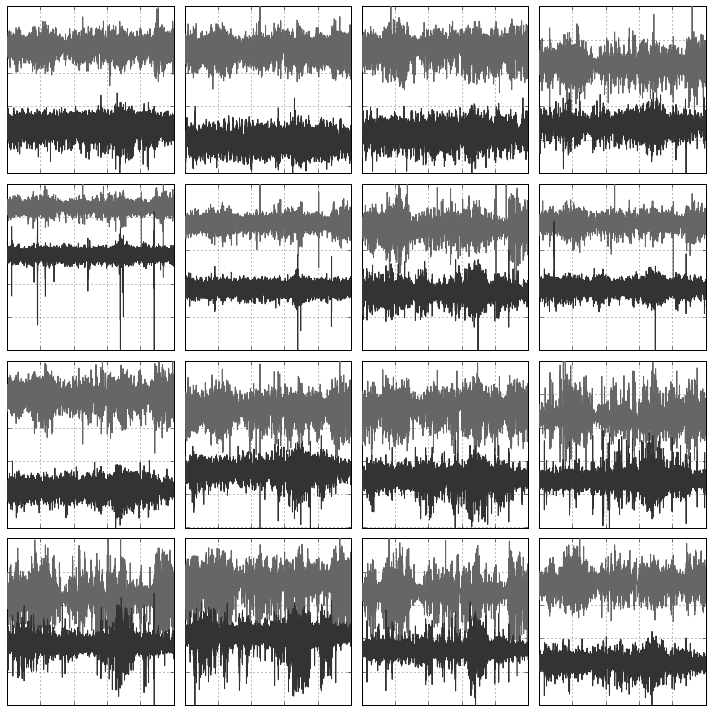

In [231]:
fig = plt.figure(figsize = (10,10))

#plt.suptitle('patient\# ' + str(patient_num) + ' sample # ' + str(sample_num), y = 1.015, size = suptitle_size)

gs = matplotlib.gridspec.GridSpec(4, 4)

offset = 500

for i in range(num_channels):
    interictal_data = get_channel(interictal_df, i)
    preictal_data = get_channel(preictal_df, i)
    
    ax = plt.subplot(gs[i])
    
    plt.plot(interictal_data + offset, zorder = 100, c = gray_color)
    plt.plot(preictal_data, zorder = 100, c = darkgray_color)
    
    
    plt.xlim(0, len(preictal_data))
    rng = np.max(interictal_data+offset) - np.min(preictal_data)
    plt.ylim(np.min(preictal_data), np.max(interictal_data + offset))
    
    plt.grid()
    plt.xticks([i*len(preictal_data)/5. for i in range(5)])
    plt.yticks([np.min(preictal_data) + i*rng/5. for i in range(5)])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

fig.tight_layout()

save_file_path = '/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/figs/' + str(patient_num) + '_' + \
str(sample_num) + '_mosaic.png'
plt.savefig(save_file_path, dpi = 300)

plt.show()

# Spectral analysis

In [ ]:
fig = plt.figure(figsize = (10,10))

#plt.suptitle('patient\# ' + str(patient_num) + ' sample # ' + str(sample_num), y = 1.015, size = suptitle_size)

gs = matplotlib.gridspec.GridSpec(4, 4)

offset = 500
nperseg = 1000

for i in range(num_channels):
    
    interictal_data = get_channel(interictal_df, i)
    interictal_freq_data = scipy.signal.welch(interictal_data, nperseg = nperseg)[1]
    
    preictal_data = get_channel(preictal_df, i)
    preictal_freq_data = scipy.signal.welch(interictal_data, nperseg = nperseg)[1]
    
    
    ax = plt.subplot(gs[i])
    
    plt.loglog([i for i in xrange(len(interictal_freq_data))], interictal_freq_data + offset, zorder = 100, c = gray_color)
    plt.loglog([i for i in xrange(len(preictal_freq_data))], preictal_freq_data, zorder = 100, c = darkgray_color)
    
    
    plt.xlim(0, len(preictal_freq_data))
    rng = np.max(interictal_freq_data+offset) - np.min(preictal_freq_data)
    #plt.ylim(np.min(preictal_freq_data), np.max(interictal_freq_data + offset))
    
    plt.grid()
    #plt.xticks([i*len(preictal_freq_data)/5. for i in range(5)])
    #plt.yticks([np.log(np.min(preictal_freq_data)) + np.log((i+1)*rng/5.) for i in range(5)])
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])

fig.tight_layout()

save_file_path = '/home/preston/Desktop/Programming/datasci/projects/eeg_seizure/figs/' + str(patient_num) + '_' + \
str(sample_num) + '_freq_mosaic.png'
plt.savefig(save_file_path, dpi = 300)

plt.show()